<a href="https://colab.research.google.com/github/carolinaquinelato/APP_PREDICAO_DIABETES/blob/main/RSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISE DE SOBREVIDA PARA PACIENTES COM CÂNCER DE MAMA

In [ ]:
!pip install -q scikit-survival

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

import pickle
import joblib

# ANÁLISE EXPLORATÓRIA

In [ ]:
link = 'https://raw.githubusercontent.com/carolinaquinelato/app_predicao_sobrevida/master/BancoR.csv'
base = pd.read_csv(link, sep=';')
base = base.drop(['Raca'], axis=1)

In [ ]:
base

,Idade,Estadiamento,TamanhoTumor,Estrogenio,Progesterona,SurvivalMonths,Status
0,2,1,1,1,1,1,0
1,2,1,1,1,1,2,0
2,1,2,1,1,1,2,1
3,2,2,2,1,1,2,1
4,1,1,1,1,1,3,1
...,...,...,...,...,...,...,...
4019,2,2,2,1,1,107,0
4020,2,1,2,2,2,107,0
4021,2,2,2,2,2,107,0
4022,1,2,2,1,1,107,0


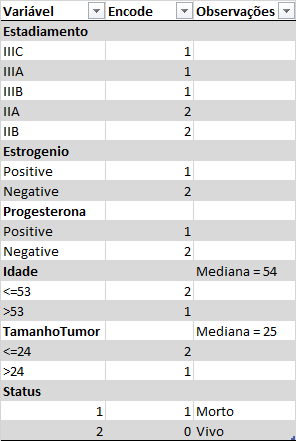


Ver censuras

In [ ]:
print(f'Number of samples: {len(base)}')
print(f'Number of right censored samples: {len(base.query("Status == 0"))}')
print(f'Percentage of right censored samples: {100*len(base.query("Status == 0"))/len(base):.1f}%')

Number of samples: 4024
Number of right censored samples: 3408
Percentage of right censored samples: 84.7%


# MODELO

## Pré-processamento

Separando o que são variáveis independentes e o que é variável resposta

In [ ]:
X = base[base.columns.to_list()[:-2]]
y = base[base.columns.to_list()[-2:]]

In [ ]:
X.head().style.hide_index()

Idade,Estadiamento,TamanhoTumor,Estrogenio,Progesterona
2,1,1,1,1
2,1,1,1,1
1,2,1,1,1
2,2,2,1,1
1,1,1,1,1


In [ ]:
X.shape

(4024, 5)

In [ ]:
y.head().style.hide_index()

SurvivalMonths,Status
1,0
2,0
2,1
2,1
3,1


In [ ]:
y.shape

(4024, 2)

Para o modelo RSF a primeira coluna precisa ser o evento e a segunda o tempo até o evento. Então, vou reorganizar o y.

In [ ]:
y = y[['Status', 'SurvivalMonths']]
y.head().style.hide_index()

Status,SurvivalMonths
0,1
0,2
1,2
1,2
1,3


Precisamos transformar o y em um array para ficar no formato exigido pelo modelo de RSF

In [ ]:
# df to array
y = y.to_numpy()

#List of tuples
aux = [(e1,e2) for e1,e2 in y]

#Structured array
y_array = np.array(aux, dtype=[('Status', '?'), ('SurvivalMonths', '<f8')])
y_array

array([(False,   1.), (False,   2.), ( True,   2.), ..., (False, 107.),
       (False, 107.), (False, 107.)],
      dtype=[('Status', '?'), ('SurvivalMonths', '<f8')])

## Treino

Separando 30% para teste e 70% para treino

In [ ]:
#random state para garantir que sempre vamos obter o mesmo resultado
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=0.30, random_state=random_state)

### Com os dados do R pré-definidos pela 

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)

In [ ]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_jobs=-1, random_state=20)

In [ ]:
rsf.score(X_test, y_test)

0.6985328989422026

### Achando os melhores parâmetros com RandomizedSearchCV

In [ ]:
rsf_search = RandomSurvivalForest(max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)

In [ ]:
params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15, 50],
    'min_samples_leaf': [5, 10, 15, 30],
    'min_samples_split': [5, 10, 15, 30]
}

In [ ]:
rsf_random_search = RandomizedSearchCV(rsf_search, param_distributions=params, n_iter=50, n_jobs=-1, cv=3, random_state=0)
search = rsf_random_search.fit(X_train, y_train)

In [ ]:
print(
    f"The c-index of random survival forest using a {search.__class__.__name__} is "
    f"{search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {search.best_params_}"
)

The c-index of random survival forest using a RandomizedSearchCV is 0.700
The best set of parameters is: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 30, 'max_depth': 15}


In [ ]:
n_estimators = search.best_params_['n_estimators']
max_depth = search.best_params_['max_depth']
min_samples_leaf = search.best_params_['min_samples_leaf']
min_samples_split = search.best_params_['min_samples_split']

In [ ]:
rsf_best = RandomSurvivalForest(random_state=42, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
rsf_best.fit(X_train, y_train)
ci_rsf = concordance_index_censored(y_test["Status"], y_test["SurvivalMonths"], rsf_best.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.700


## Permutation-based Feature Importance
The implementation is based on scikit-learn's Random Forest implementation and inherits many features, such as building trees in parallel. What's currently missing is feature importances via the feature_importance_ attribute. This is due to the way scikit-learn's implementation computes importances. It relies on a measure of impurity for each child node, and defines importance as the amount of decrease in impurity due to a split. For traditional regression, impurity would be measured by the variance, but for survival analysis there is no per-node impurity measure due to censoring. Instead, one could use the magnitude of the log-rank test statistic as an importance measure, but scikit-learn's implementation doesn't seem to allow this.

Fortunately, this is not a big concern though, as scikit-learn's definition of feature importance is non-standard and differs from what Leo Breiman proposed in the original Random Forest paper. Instead, we can use permutation to estimate feature importance, which is preferred over scikit-learn's definition. This is implemented in the permutation_importance function of scikit-learn, which is fully compatible with scikit-survival.

 



In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    rsf_best, X_test, y_test, n_repeats=15, random_state=random_state
)

In [ ]:
feature_importances = pd.DataFrame(
    {k: feature_importances[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)
feature_importances

,importances_mean,importances_std
Estadiamento,0.074459,0.010838
Progesterona,0.023787,0.008931
Estrogenio,0.023373,0.004287
Idade,0.006052,0.004780
TamanhoTumor,0.004656,0.002068


Text(0.5, 1.0, 'Feature importance')

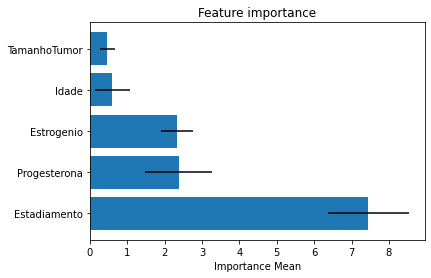

In [ ]:
variaveis = ['Estadiamento', 'Progesterona', 'Estrogenio', 'Idade', 'TamanhoTumor']
impt_mean = feature_importances['importances_mean']*100
std = feature_importances['importances_std']*100

plt.barh(variaveis, impt_mean, xerr = std)
plt.xlabel('Importance Mean')
plt.title('Feature importance')

## Predição

Testando e analisando em alguns casos da base conforme as variáveis mais importantes

In [ ]:
X_test_sorted = X_test.sort_values(by=["Estadiamento", "Progesterona", "Estrogenio"])
X_test_sel = X_test_sorted.head(1)

X_test_sel

,Idade,Estadiamento,TamanhoTumor,Estrogenio,Progesterona
2393,1,1,2,1,1


In [ ]:
pd.Series(rsf_best.predict(X_test_sel)).sort_values()

0    11.079609
dtype: float64

Podemos ver um risco maior para os 3 últimos casos.

Probabilidade de sobrevivência

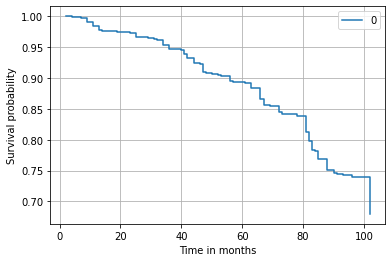

In [ ]:
surv = rsf_best.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf_best.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)

Predição da função de Hazard acumulada

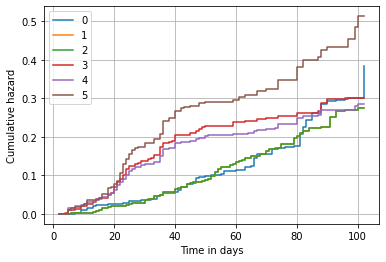

In [ ]:
surv = rsf_best.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf_best.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Salvando o modelo pra usar no app

In [ ]:
filename = 'rsf_2022.pkl'
pickle.dump(rsf_best, open(filename, 'wb'))

In [ ]:
filename = 'rsf_2022.sav'
joblib.dump(rsf_best, filename)

['rsf_2022.sav']

In [ ]:
hazard = pd.DataFrame({'Hazard Acumulado': value for value in surv})
hazard['Meses'] = hazard.index
hazard

,Hazard Acumulado,Meses
0,0.999933,0
1,0.999768,1
2,0.999510,2
3,0.999414,3
4,0.999139,4
...,...,...
92,0.739814,92
93,0.739686,93
94,0.739686,94
95,0.738767,95


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


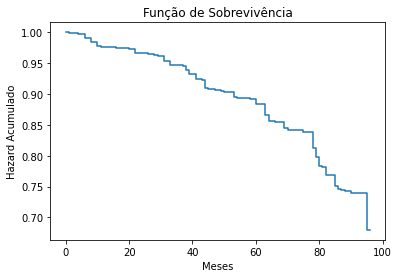

In [ ]:
sns.lineplot(hazard['Meses'],hazard['Hazard Acumulado'], drawstyle='steps-pre').set(title='Função de Sobrevivência')
plt.show()